# Purpose

The purpose of this project is to evaluate a representative set of classifiers in as pessimistic a way as possible.  Therefore, the perspective chosen is white-box adversarial.  The adversary can see detailed statistics for the classifier under evaluation and use that information to construct deceptive inputs.  The adversary starts by introducing small changes to well-classified inputs and then proceeds to increase the size of the change until the classifier picks the wrong class.

    # "Effectiveness" in increasing order of strength:
    # (0) The classifier still outputs the correct class for a set of features it classified correctly in the past.
    # (1) The classifier outputs the wrong class for a set of features it used to classify correctly.
    # (2) The image is not noticeably different from the original input.
    # (2) The classifier outputs the class we are trying to get it to output.

    # Strategy 2:
    # Find the top-confused other-class that has *THIS* class as *ITS* top-confused class.
    #   The idea here is that these 2 classes are easy to confuse, so we don't have to push very hard to tip one into the other using the other's features.
    # Consider the deceptor weighting that normalizes row sums to 1, combines reciprocal relationships, and scores the deceptor as the max of the reciprocal-relationship and the one-sided relationship:
    #   UnitD = axis-divide(D, axis-max(axis-sum(D,row),1))      # Normalized confusion/deceptor rows (sum of row == 1).  Careful to avoid divide-by-zero!
    #   D = axis-argmax(np.max(np.sqrt(UnitD * UnitD.T), UnitD)) # sqrt() over the interval [0,1) should make the comparison of the product to the un-multiplied UnitD more fair.
    # ... which could represent a decent compromise between Strategy 1 and Strategy 2.

    #   Strategy 3:
    #     Find the top 2 classes it recognizes, "a", and "b".
    #     Try to get everything to be classified as the top class...
    #     ... EXCEPT the top class which we should try to get classified as the 2nd class.
    #     D is a matrix composed entirely of deveptive images to mix with X

    # Strategy 4:
    # Use the the least-often-confused non-zero other-class for each class.
    #   The idea here is that it will be easier to find a small set of archetypes that confuse the classifier.
    #   These are potentially the outliers of the other class that are most like THIS class.



In [2]:
print("Loading code modules...")
from datetime import datetime as dt
import numpy                  as np
import numpy.random           as prng
import pandas                 as pd

# Visualization
import matplotlib.pyplot      as plt
import seaborn                as sns

#-from sklearn.decomposition   import PCA

# Preprocessing and metasearch
#-from sklearn.preprocessing   import Normalizer,StandardScaler,MinMaxScaler,PolynomialFeatures
#-from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.linear_model    import Ridge,Lasso,RidgeClassifier
from sklearn.neighbors       import KNeighborsClassifier                as KNN
from sklearn.naive_bayes     import GaussianNB                          as NB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm             import SVC
from sklearn.svm             import LinearSVC
from sklearn                 import svm
from sklearn.tree            import DecisionTreeClassifier              as DT
from sklearn.ensemble        import RandomForestClassifier              as RF, AdaBoostClassifier as AB
from sklearn.neural_network  import MLPClassifier                       as NN
from sklearn.metrics         import classification_report,confusion_matrix,accuracy_score

#ply.init_notebook_mode(connected = True)
print("Loaded.")

Loading code modules...
Loaded.


In [3]:
# Prepare the Data
print("Preparing the data.")

labels = ['T-shirt/top', 'Pants', 'Pullover', 'Dress', 'Jacket', 'Sandal', 'Shirt', 'Shoe', 'Bag', 'Boot']

def read_df(purpose):
    df = pd.read_csv('fashionmnist/fashion-mnist_'+purpose+'.csv')
    Y = df['label']
    X = df.drop('label',axis=1)/255.0  # Scale the data to [0..1] by dividing by max(X).
    #-le = sklearn.preprocessing.LabelEncoder()
    #-le.fit(train['Outcome'])
    #-print(list(le.classes_))
    #-X = MinMaxScaler().fit_transform(X)
    #-X = PolynomialFeatures(2).fit_transform(X)
    return X.values,Y.values           # Get the NumPy arrays our of the data frames.

Xtrn,Ytrn = read_df('train')
Xtst,Ytst = read_df('test')

class_counts = np.unique(Ytrn, return_counts=True)[1]
class_probs = class_counts / np.sum(class_counts)
n_classes = class_counts.shape[0]

print("%d classes (counts: %s, probabilities: %s)" % (n_classes, str(class_counts), str(class_probs)))

# Subset the data for the initial runs.
Xtrn = Xtrn[0:10000]
Ytrn = Ytrn[0:10000]
Xtst = Xtst[0:3000]
Ytst = Ytst[0:3000]

print(Xtrn.shape)
print(Xtst.shape)
print("Prepared.")

Preparing the data.
10 classes (counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000], probabilities: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1])
(10000, 784)
(3000, 784)
Prepared.


In [6]:
# Evaluate the classifiers
print("Evaluating the classifiers.")
#-param_grid = {
#-    'C':      [.1, 1, 10, 100, 1000],
#-    'gamma':  [1, .1, .01, .001, .0001],
#-    'kernel': ['rbf']
#-}

def rmse(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted) - np.log1p(y_real), 2)))

def percenterror(y_predicted, y_real):
    return np.round(100 * np.mean(np.abs(y_predicted - y_real)) / np.mean(y_real), 1)

def perceptualdiff(a, b):
    """Calculate the perceptual difference between 2 (grayscale) images using the L1 norm.
       http://web.mit.edu/sinhalab/Papers/sinha_russell2011.pdf suggests L1 is better."""
    return np.linalg.norm(a-b, ord=1)

classifiers = [
    {'name': 'RidgeClassifier'},
]

classifier_names = [
    #-'Ridge',              # Disabled: seems to produce many outputs far outside the class-label set.
    'RidgeClassifier',
    #-'Lasso',              # Disabled: produces outputs that are not in the class-labels set ([0..9]).
    #-'KNN',
    'NaiveBayes',
    'QDA',
    'LDA',
    #-'LinearSVC',
    'SVM (SVC(linear))',
    #-'SVC(rbf)',             # other SVC funcs: poly, sigmoid, precomputed
    'DecisionTree',
    'RandomForest',
    'AdaBoost',
    'NN',
]
classifier_objs = [
    #-Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    RidgeClassifier(),
    #-Lasso(alpha=0.015),
   #- KNN(n_neighbors=3, n_jobs=-1),
    NB(),
    QDA(priors=class_probs),   #-priors=None, reg_param=0.0),
    LDA(priors=class_probs),   #-n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001),
    #-LinearSVC(),
    SVC(kernel='linear', C=0.015),
    #-SVC(kernel='rbf', random_state=0),  #-SVC(kernel="linear", C=0.025),  #-SVC(gamma=2, C=1)
    #-SVM(),
    DT(max_depth=7),
    RF(),
    AB(),
    NN(),     #//TODO// setup parameters and such?
]

# Train the classifiers
print('################'*5)
print('Train:')
print(dt.now())
for name,classifier in zip(classifier_names,classifier_objs):
    print('--', name)
    classifier.name = name     # Save the name of the classifier for later use.
    classifier.fit(Xtrn,Ytrn)  # Fit
print(dt.now())
print('################'*5)

Evaluating the classifiers.
################################################################################
Train:
2017-12-10 03:10:28.573726
-- RidgeClassifier
-- NaiveBayes
-- QDA


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


-- LDA
-- SVM (SVC(linear))
-- DecisionTree
-- RandomForest
-- AdaBoost
-- NN
2017-12-10 03:11:11.223810
################################################################################


################################################################################
Score the classifiers:
2017-12-10 06:28:25.731076
--------------------------------------------------------------------------------
-- RidgeClassifier
--------------------------------------------------------------------------------
   Test Accuracy: 80.5 %
   Test  % error: 13.0 	RMSe: 0.417267407301
Confusion Matrix:
 ..................


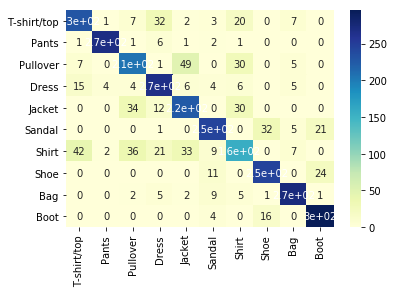

--------------------------------------------------------------------------------
-- NaiveBayes
--------------------------------------------------------------------------------
   Test Accuracy: 53.57 %
   Test  % error: 27.5 	RMSe: 0.501295092726
Confusion Matrix:
 ..................


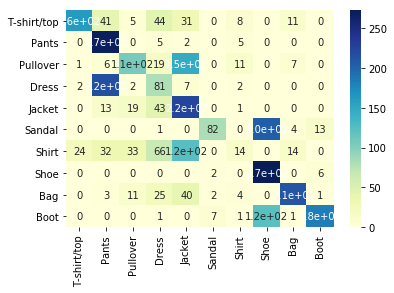

--------------------------------------------------------------------------------
-- QDA
--------------------------------------------------------------------------------
   Test Accuracy: 58.8 %
   Test  % error: 23.4 	RMSe: 0.503868261526
Confusion Matrix:
 ..................


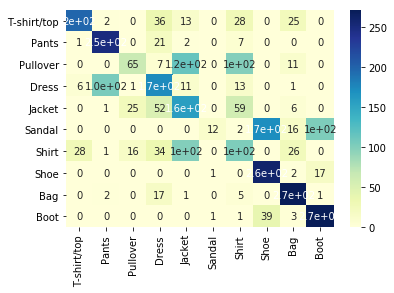

--------------------------------------------------------------------------------
-- LDA
--------------------------------------------------------------------------------
   Test Accuracy: 80.73 %
   Test  % error: 13.2 	RMSe: 0.42530863558
Confusion Matrix:
 ..................


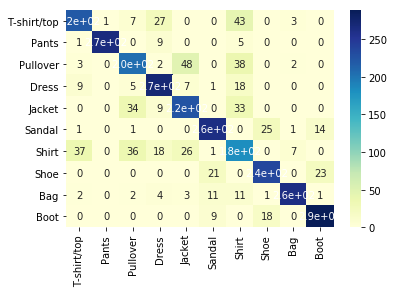

--------------------------------------------------------------------------------
-- SVM (SVC(linear))
--------------------------------------------------------------------------------
   Test Accuracy: 83.93 %
   Test  % error: 11.8 	RMSe: 0.427533462077
Confusion Matrix:
 ..................


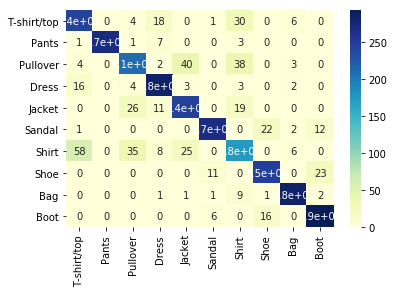

--------------------------------------------------------------------------------
-- DecisionTree
--------------------------------------------------------------------------------
   Test Accuracy: 74.9 %
   Test  % error: 17.7 	RMSe: 0.501705726164
Confusion Matrix:
 ..................


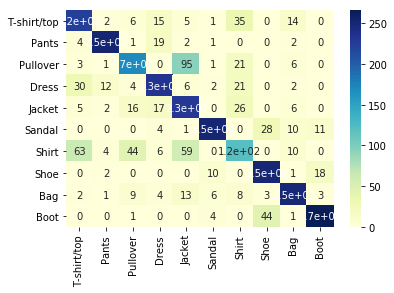

--------------------------------------------------------------------------------
-- RandomForest
--------------------------------------------------------------------------------
   Test Accuracy: 82.73 %
   Test  % error: 12.8 	RMSe: 0.440661519289
Confusion Matrix:
 ..................


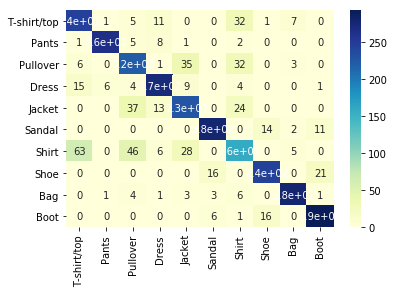

--------------------------------------------------------------------------------
-- AdaBoost
--------------------------------------------------------------------------------
   Test Accuracy: 46.7 %
   Test  % error: 30.6 	RMSe: 0.699636022698
Confusion Matrix:
 ..................


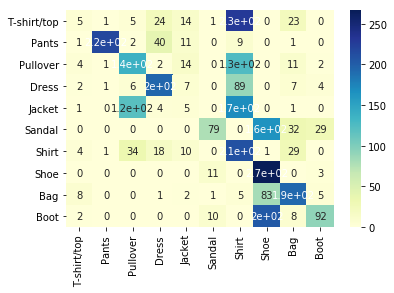

--------------------------------------------------------------------------------
-- NN
--------------------------------------------------------------------------------
   Test Accuracy: 85.37 %
   Test  % error: 10.4 	RMSe: 0.401480123885
Confusion Matrix:
 ..................


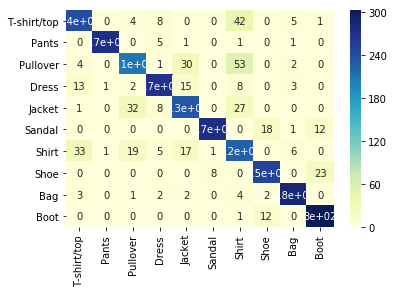

2017-12-10 06:28:40.534581
################################################################################


In [77]:
# Score the classifiers (and possibly store their confusion matrices).
print('################'*5)
print('Score the classifiers:')
print(dt.now())
def score(classifiers, X, Y, append_metrics=False):
    for classifier in classifiers:
        # Predict
        print('----------------'*5)
        print('--', classifier.name)
        print('----------------'*5)
        Yh = classifier.predict(X)
        Yh_rounded = np.round(Yh)  # Round to the nearest class label.

        # Accuracy
        accuracy  = round(100*accuracy_score(Y, Yh_rounded), 2)
        pct_error = percenterror(Y,Yh)
        rms_error = rmse(Y,Yh)
        print('   Test Accuracy:', accuracy, '%')
        print('   Test  % error:', pct_error, '\tRMSe:', rms_error)

        # Confusion Matrix
        title = 'Confusion Matrix:\n'
        print(title, '.'*len(title))
        conf  = confusion_matrix(Y, Yh_rounded)
        wrong = conf * (np.ones_like(conf) - np.eye(n_classes))  # Mask out the correct classes.
        label = range(n_classes)
        sns.heatmap(conf, annot=True, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
        plt.show()
        #-print(conf)
        if append_metrics:
            classifier.accuracy  = accuracy
            classifier.pct_error = pct_error
            classifier.rms_error = rms_error
            classifier.conf      = conf
            classifier.wrong     = wrong

        # Classification Report
        #-title = 'Classification Report:\n'
        #-print(title, '.'*len(title))
        #-print(classification_report(Y, Yh_rounded))

score(classifier_objs, Xtst, Ytst, append_metrics=True)
print(dt.now())
print('################'*5)

In [8]:
class Image:
    def __init__(self, Cclass, Cimage, Dclass, Dimage):
        """C = correct, D = distorted/deceived"""
        self.cclass = Cclass
        self.cimage = Cimage
        self.dclass = Dclass
        self.dimage = Dimage
        
# Deceive the classifiers
print('################'*5)
print('Deceive:')
print(dt.now())

# For each classifier:
for classifier in classifier_objs:
    print('----------------'*5)
    print('--', classifier.name)
    print('----------------'*5)
    print(dt.now())

    # Setup a place to keep evaluation data.
    classifier.accuracies = []
    classifier.pct_errors = []
    classifier.rms_errors = []
    classifier.conf_mtrxs = []

    ############################################################################################
    # Get the correctly-classified ("C") test instances.
    # --------------------------------------------------
    # The assumption is that these are the things the classifier is good at classifying, so
    # small amounts of their features mixed with the the features of a different class will be
    # better at deceiving the classifier.
    ############################################################################################

    # Classify the test inputs.
    Yh = classifier.predict(Xtst)

    # Get the correctly classified instances
    Cidx  = np.where(np.equal(Yh,Ytst))[0]            # Get the indices where Yh and Y match...
    Cx,Cy = Xtst[Cidx],Ytst[Cidx]                     # Extract the feature and label vectors for correct predictions.

    # Sort by class so all instances of the same class are next to each other.  This helps us to produce
    # contiguous deceptors of the same class without having to do lots of fancy array indexing later.
    sort_indices = Cy.argsort(axis=0)                 # Find a set of indices that would sort Cy by class.
    Cx,Cy = Cx[sort_indices],Cy[sort_indices]         # Apply the indices to all of the correct Mats.

    # Make a lookup table of the occurrences of each class: [[class, index, count], ...].
    # Not every class will be represented in the correct outputs of the classifier.  This code is careful to
    # make sure even the unrepresented classes show up in Cidx.
    Cidx = np.vstack(np.unique(Cy, return_index=True, return_counts=True)) # Count the occurrences of each class and find the first occurrence in Cy.  Since Cy is sorted, the first+count covers all instances of the class.
    I = np.zeros((3, n_classes), dtype=int)           # Make sure every class has a column.
    I[0,:] = np.arange(n_classes)                     # Initialize row 0 to the class "labels".
    I[1:,Cidx[0,:]] = Cidx[1:,:]                      # Copy in the initial index in Cx/Cy and the count of the class.
    Cidx = I.T                                        # Move it back into Cidx.
    print("Correct class index (<class,index-of-1st,unique-count>^T) = \n" + str(Cidx.T))
    
    ############################################################################################
    # Build deceptor ("D") labels and features for the classifier.
    ############################################################################################

    # Strategy 1: Find the top-confused other-class for each class and select instances of that class as "deceptors".
    deceptors = classifier.wrong                      # Find the classes this classifier mis-classifies each class as.
    deceptors = np.argmax(deceptors, axis=1)          # Get the classes (equivalent to indices!) of the best deceptors (max from each row).
    Dy        = deceptors[Cy]                         # Get the deceptor for each correctly classified label.  Could also use np.take() here.
    
    Dx = np.empty_like(Cx)
    for i in Cidx[:,0]:
        Cclass        = Cidx[i,0]                     # Get the class from the index.
        Cfirst,Ccount = Cidx[i,1],Cidx[i,2]           # Get the range of the actual class in Cx...
        Clast         = Cfirst + Ccount               # ... up-to-but-not-including Clast.

        Dclass        = deceptors[Cclass]             # Find the corresponding deceptor class.
        Dfirst,Dcount = Cidx[Dclass,1],Cidx[Dclass,2] # Get the range of the deceptor class in Cx...
        Dlast         = Dfirst + Dcount               # ... up-to-but-not-including Dlast.

        Dfeatures = Cx[Dfirst:Dlast,:]                # Get the deceptive features out of Cx.
        Dchosen   = prng.choice(Dcount, Ccount, replace=True)
        Dx[Cfirst:Clast,:] = Dfeatures[Dchosen,:]     # Sample from the Dcount features Ccount times
    
    # Setup a place for keeping images that change the classifier's decision...
    classifier.distortions = []    # ... to ANY incorrect class.
    classifier.deceptions  = []    # ... to the incorrect class chosen by the attacker.

    # For each pixel transfer function:
    for i,f in enumerate((lambda x: np.ones_like(x),                 # Identity pixel transfer function.
                          lambda x: prng.uniform(size=x.shape),      # Uniform noise pixel transfer function.
                          lambda x: np.minimum(np.ones_like(x),      # Gaussian noise.
                                               np.maximum(np.zeros_like(x),
                                                          prng.normal(.5, .125, size=x.shape))))):
        # The first measurement is with s = 0.0 (unaltered input features).
        accuracies = [classifier.accuracy]
        pct_errors = [classifier.pct_error]
        rms_errors = [classifier.rms_error]
        conf_mtrxs = [classifier.conf]
        distortions = []
        deceptions  = []
        
        classifier.accuracies.append(accuracies)
        classifier.pct_errors.append(pct_errors)
        classifier.rms_errors.append(rms_errors)
        classifier.conf_mtrxs.append(conf_mtrxs)
        classifier.distortions.append(distortions)
        classifier.deceptions.append(distortions)
        
        # For each scale-value to apply to the transfer function:
        for s in np.arange(0.01, 0.99, 0.01):
            Xdcv = Cx*(1-s) + s*f(Dx)*Dx  # Construct the deceptive input at scale s.
            Yh = classifier.predict(Xdcv) # Predict the classes from the deceptive inputs.
            Yh_rounded = np.round(Yh)     # Round to the nearest class label.

            # Save data to quantify the classification error that arises.  This data will be extracted and
            # graphed later.
            accuracies.append(round(100*accuracy_score(Cy, Yh_rounded), 2))
            pct_errors.append(percenterror(Cy, Yh))
            rms_errors.append(rmse(Cy, Yh))
            conf_mtrxs.append(confusion_matrix(Cy, Yh_rounded))

            ##########################################################
            # Save 20 images at each scale value.
            ##########################################################
            # --------------------------------------------------------
            # 5 of the images that are now incorrectly classified:
            #  min difference from un-confused and its corresponding unaltered image.
            #  median ...
            #  75%-ile ...
            #  90%-ile ...
            #  99%-ile ...
            _x = np.sqrt(np.sum(np.square(Cx - Xdcv), axis=1))  # Compute the differences in the images.
            _y = Cy - Yh_rounded          # Compute the difference in predicted class compared to correct class.
            _z = Dy - Yh_rounded          # Compute the difference in predicted class compared to deceptive class.
            Sidx = np.where(_y != 0)[0]   # Get the indices where the new prediction doesn't match (deception was minimally successful ("S")).
            Ox,Oy = Cx[Sidx],Cy[Sidx]     # Get the original correctly classified images and labels to move with the deceptive ones.
            Sx,Sy = Dx[Sidx],Dy[Sidx]     # Extract the feature and label vectors for deceived predictions.
            _x,_y,_z = _x[Sidx],_y[Sidx],_z[Sidx]     # Only save the image differences and class differences where the class was changed.

            # Sort by the differences in the images.
            permutation = _x.argsort(axis=0)         # Find a set of indices that would sort _x (image differences).
            Ox,Oy = Ox[permutation],Oy[permutation]  # Sort Ox and Oy.
            Sx,Sy = Sx[permutation],Sy[permutation]  # Sort Sx and Sy.
            _x,_y,_z = _x[permutation],_y[permutation],_z[permutation]  # Sort the image differences and label differences.

            distorted = []
            n = Sx.shape[0]
            #-print("distorted n = "+str(n))
            if n > 0:
                for c in (.0, .5, .75, .9, .99):
                    row = round(c*(n-1))
                    distorted.append(Image(Oy[row], Ox[row,:], Sy[row], Sx[row,:]))
            distortions.append(distorted)

            # --------------------------------------------------------
            # 5 of the images that are now incorrectly classified _as what the deceptor wanted_:
            #  min difference from un-confused
            #  median ...
            #  75%-ile ...
            #  90%-ile ...
            #  99%-ile ...

            # Subset further by the rows that match the deceptor class Dy (i.e. _z == 0).
            Sidx = np.where(_z == 0)[0]
            Ox,Oy = Ox[Sidx],Oy[Sidx]     # Extract the correct feature and label vectors for deceived predictions.
            Sx,Sy = Sx[Sidx],Sy[Sidx]     # Extract the feature and label vectors for deceived predictions.
            _x,_y,_z = _x[Sidx],_y[Sidx],_z[Sidx]     # Only save the image differences and class differences where the class was changed.
            
            deceived = []
            n = Sx.shape[0]
            #-print("deceived n = "+str(n))
            if n > 0:
                for c in (.0, .5, .75, .9, .99):
                    row = round(c*(n-1))
                    deceived.append(Image(Oy[row], Ox[row,:], Sy[row], Sx[row,:]))
            deceptions.append(deceived)
            
        #/end scale value (s)
        #-print(len(classifier.accuracies[i]))
        #-print(len(classifier.pct_errors[i]))
        #-print(len(classifier.rms_errors[i]))
        #-print(len(classifier.conf_mtrxs[i]))
    # /end pixel transfer function (i,f)
    print(dt.now())
# /end classifier
print(dt.now())
print('################'*5)

################################################################################
Deceive:
2017-12-10 03:11:26.187694
--------------------------------------------------------------------------------
-- RidgeClassifier
--------------------------------------------------------------------------------
2017-12-10 03:11:26.188856
Correct class index (<class,index-of-1st,unique-count>^T) = 
[[   0    1    2    3    4    5    6    7    8    9]
 [   0  230  499  705  972 1197 1443 1600 1846 2119]
 [ 230  269  206  267  225  246  157  246  273  296]]
2017-12-10 03:11:46.082206
--------------------------------------------------------------------------------
-- NaiveBayes
--------------------------------------------------------------------------------
2017-12-10 03:11:46.082864
Correct class index (<class,index-of-1st,unique-count>^T) = 
[[   0    1    2    3    4    5    6    7    8    9]
 [   0  162  431  537  618  843  925  939 1212 1424]
 [ 162  269  106   81  225   82   14  273  212  183]]
201

In [10]:
import pickle
for i,classifier in enumerate(classifier_objs):
    pickle.dump(classifier.deceptions,  open('deceptions-' +str(i)+'.pickle', 'wb'))
    pickle.dump(classifier.distortions, open('distortions-'+str(i)+'.pickle', 'wb'))
    pickle.dump(classifier.accuracies,  open('accuracies-' +str(i)+'.pickle', 'wb'))
    pickle.dump(classifier.pct_errors,  open('pct_errors-' +str(i)+'.pickle', 'wb'))
    pickle.dump(classifier.rms_errors,  open('rms_errors-' +str(i)+'.pickle', 'wb'))
    pickle.dump(classifier.conf_mtrxs,  open('conf_mtrxs-' +str(i)+'.pickle', 'wb'))

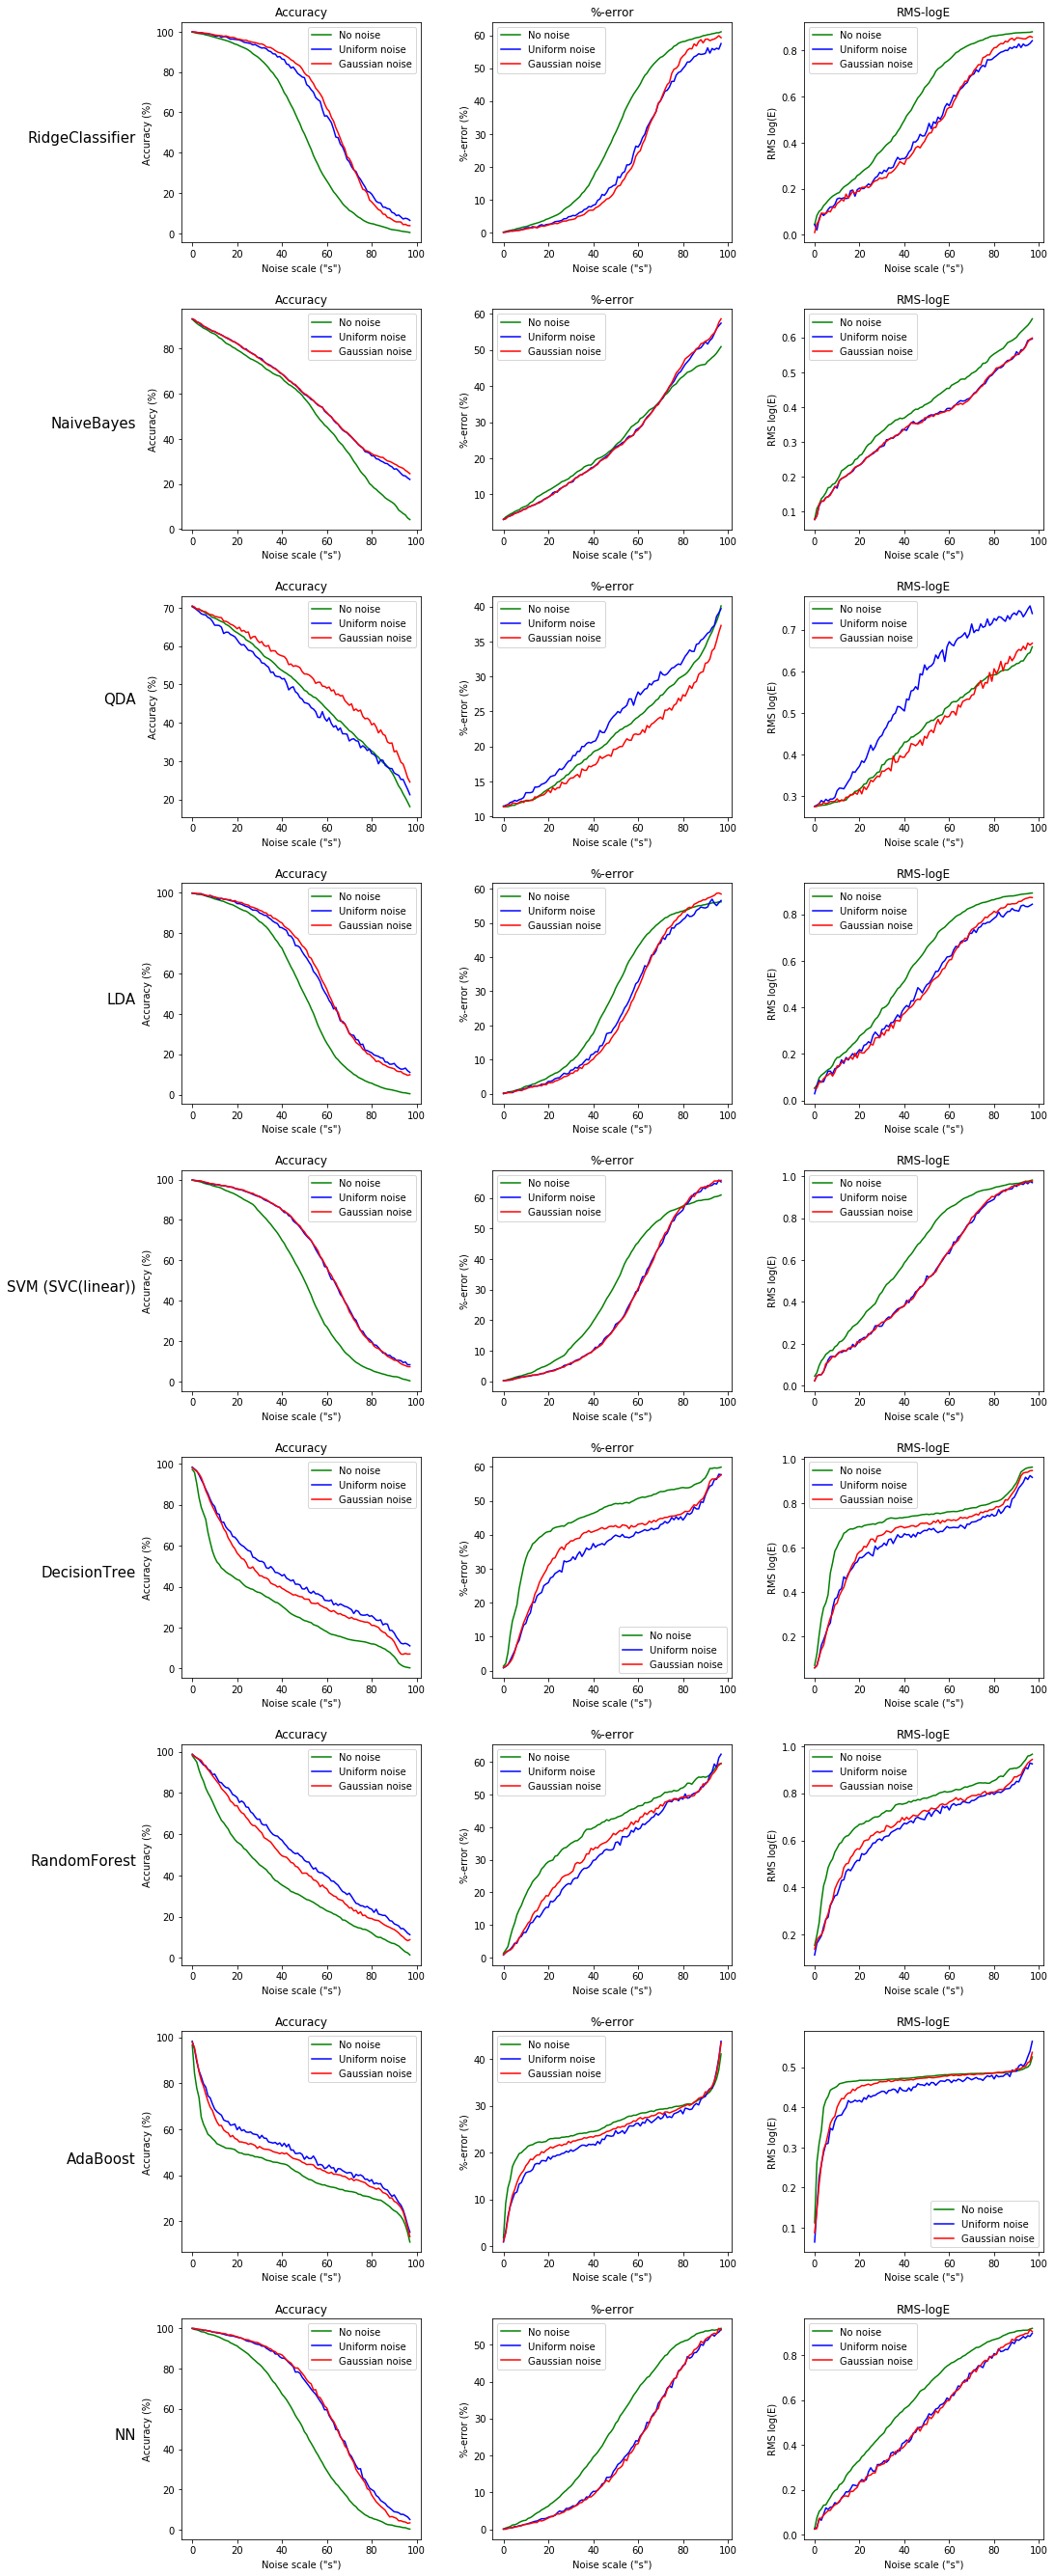

In [11]:
# Produce diagrams
j = 1
figure = plt.figure(figsize=(16, 48))
rows = len(classifier_objs)
cols = 3

for i,classifier in enumerate(classifier_objs):
    ax = plt.subplot(rows, cols, j + 0)
    ax.text(-25, 45, classifier.name, size=15, horizontalalignment='right')

    ax.set_title("Accuracy")
    ax.plot(classifier.accuracies[0][1:], 'g-', label='No noise')
    ax.plot(classifier.accuracies[1][1:], 'b-', label='Uniform noise')
    ax.plot(classifier.accuracies[2][1:], 'r-', label='Gaussian noise')
    ax.legend()
    plt.xlabel('Noise scale ("s")')
    plt.ylabel('Accuracy (%)')

    ax = plt.subplot(rows, cols, j + 1)
    ax.set_title("%-error")
    ax.plot(classifier.pct_errors[0][1:], 'g-', label='No noise')
    ax.plot(classifier.pct_errors[1][1:], 'b-', label='Uniform noise')
    ax.plot(classifier.pct_errors[2][1:], 'r-', label='Gaussian noise')
    ax.legend()
    plt.xlabel('Noise scale ("s")')
    plt.ylabel('%-error (%)')

    ax = plt.subplot(rows, cols, j + 2)
    ax.set_title("RMS-logE")
    ax.plot(classifier.rms_errors[0][1:], 'g-', label='No noise')
    ax.plot(classifier.rms_errors[1][1:], 'b-', label='Uniform noise')
    ax.plot(classifier.rms_errors[2][1:], 'r-', label='Gaussian noise')
    ax.legend()
    plt.xlabel('Noise scale ("s")')
    plt.ylabel('RMS log(E)')
    j = j + cols

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

Classifier: AdaBoost
Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the Adaboost classifier to change its a output label from 'Dress' to 'Shirt'. As you can see a quite a bit of change was needed


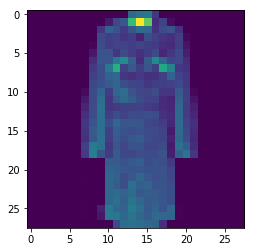

'Dress'

In [114]:
# Plot correctly-classified and deceptive images for each classifier at s values where their correclty classified images dropped quite low.
print("Classifier: "+classifier_objs[-2].name)
print("Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the Adaboost classifier to change its a output label from 'Dress' to 'Shirt'. As you can see a quite a bit of change was needed")

# -5: Which classifier to get the data for.
# 0: Get the distorted images for the noise-less deceptive image.
# 50: 50% of the deceptive image comes from the false label image and the rest comes from the true image.
# 0: 0% (minchange) of all images at this mix of false and true have L2 norms of the differences that are less than this.

x = classifier_objs[-2].distortions[0][50][0] # 0 => min change, 1=>50%-ile change, 2=>75%, 3=>90%, 4 => 99%-ile change
plt.imshow(x.cimage.reshape(28,28))  # Get the true image.
plt.show()
labels[x.cclass]                             # Get the true class.




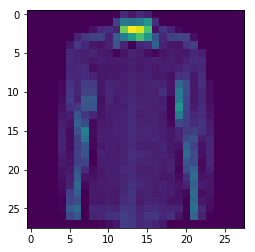

'Shirt'

In [115]:
plt.imshow(x.dimage.reshape(28,28))  # Get the deceptive image.
plt.show()
labels[x.dclass]                             # Get the deceptive class.

Classifier: SVM (SVC(linear))
Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the SVM classifier to change its a output label from 'Shoe' to 'Boot'. As you can see a quite a bit of change was needed


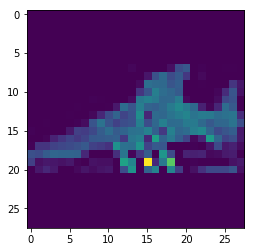

'Shoe'

In [116]:
# Plot correctly-classified and deceptive images for each classifier at s values where their correclty classified images dropped quite low.
print("Classifier: "+classifier_objs[-5].name)
print("Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the SVM classifier to change its a output label from 'Shoe' to 'Boot'. As you can see a quite a bit of change was needed")

# -5: Which classifier to get the data for.
# 0: Get the distorted images for the noise-less deceptive image.
# 50: 50% of the deceptive image comes from the false label image and the rest comes from the true image.
# 3: 90% of all images at this mix of false and true have L2 norms of the differences that are less than this.

x = classifier_objs[-5].distortions[0][50][3] # 0 => min change, 1=>50%-ile change, 2=>75%, 3=>90%, 4 => 99%-ile change
plt.imshow(x.cimage.reshape(28,28))  # Get the true image.
plt.show()
labels[x.cclass]                             # Get the true class.


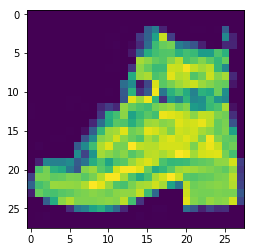

'Boot'

In [117]:
plt.imshow(x.dimage.reshape(28,28))  # Get the deceptive image.
plt.show()
labels[x.dclass]                             # Get the deceptive class.

Classifier: LDA
Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the LDA classifier to change its a output label from 'T-Shirt/Top' to 'Shirt'. As you can see a quite a bit of change was needed


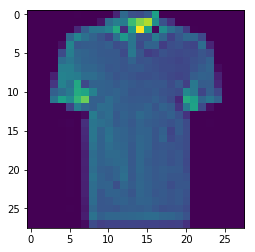

'T-shirt/top'

In [118]:
# Plot correctly-classified and deceptive images for each classifier at s values where their correclty classified images dropped quite low.
print("Classifier: "+classifier_objs[-6].name)
print("Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the LDA classifier to change its a output label from 'T-Shirt/Top' to 'Shirt'. As you can see a quite a bit of change was needed")

# -6: Which classifier to get the data for.
# 0: Get the distorted images for the noise-less deceptive image.
# 50: 50% of the deceptive image comes from the false label image and the rest comes from the true image.
# 0: 0%(min change) of all images at this mix of false and true have L2 norms of the differences that are less than this.

x = classifier_objs[-6].distortions[0][50][0] # 0 => min change, 1=>50%-ile change, 2=>75%, 3=>90%, 4 => 99%-ile change
plt.imshow(x.cimage.reshape(28,28))  # Get the true image.
plt.show()
labels[x.cclass]                             # Get the true class.


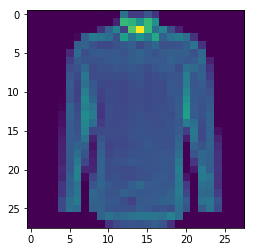

'Shirt'

In [119]:
plt.imshow(x.dimage.reshape(28,28))  # Get the deceptive image.
plt.show()
labels[x.dclass]                             # Get the deceptive class.

Classifier: QDA


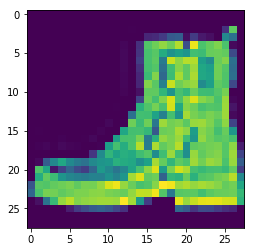

'Boot'

In [110]:
# Plot correctly-classified and deceptive images for each classifier at s values where their correclty classified images dropped quite low.
print("Classifier: "+classifier_objs[-7].name)
print("Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the QDA classifier to change its a output label from 'Boot' to 'Shoe'. As you can see a quite a bit of change was needed")

# -7: Which classifier to get the data for.
# 0: Get the distorted images for the noise-less deceptive image.
# 20: 20% of the deceptive image comes from the false label image and the rest comes from the true image.
# 3: 90% of all images at this mix of false and true have L2 norms of the differences that are less than this.
x = classifier_objs[-7].distortions[0][20][3] # 0 => min change, 1=>50%-ile change, 2=>75%, 3=>90%, 4 => 99%-ile change
plt.imshow(x.cimage.reshape(28,28))  # Get the true image.
plt.show()
labels[x.cclass]                             # Get the true class.


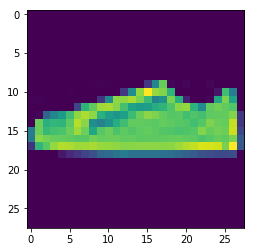

'Shoe'

In [111]:
plt.imshow(x.dimage.reshape(28,28))  # Get the deceptive image.
plt.show()
labels[x.dclass]                             # Get the deceptive class.

Classifier: DecisionTree
Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the Decision Tree classifier to change its a output label from 'Bag' to 'Jacket'. As you can see a quite a bit of change was needed


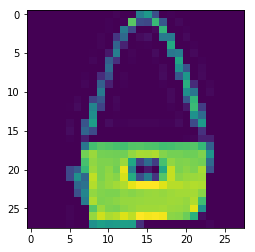

'Bag'

In [120]:
# Plot correctly-classified and deceptive images for each classifier at s values where their correclty classified images dropped quite low.
print("Classifier: "+classifier_objs[-4].name)
print("Here is an example pair of images that demonstrate how much change (measured with the the L2 norm) was required in order to get the Decision Tree classifier to change its a output label from 'Bag' to 'Jacket'. As you can see a quite a bit of change was needed")

# -4: Which classifier to get the data for.
# 0: Get the distorted images for the noise-less deceptive image.
# 25: 25% of the deceptive image comes from the false label image and the rest comes from the true image.
# 4: 99% of all images at this mix of false and true have L2 norms of the differences that are less than this.

x = classifier_objs[-4].distortions[0][25][4] # 0 => min change, 1=>50%-ile change, 2=>75%, 3=>90%, 4 => 99%-ile change
plt.imshow(x.cimage.reshape(28,28))  # Get the true image.
plt.show()
labels[x.cclass]                             # Get the true class.


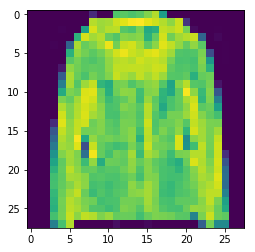

'Jacket'

In [121]:
plt.imshow(x.dimage.reshape(28,28))  # Get the deceptive image.
plt.show()
labels[x.dclass]                             # Get the deceptive class.